In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import os
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from LIP_Model import PoseRefineNet, ParsingRefineNet, PoseNet, ParsingNet
from Model import BackboneResNet

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available else "cpu"

In [3]:
N_CLASSES = 20
INPUT_SIZE = (384, 384)
BATCH_SIZE = 1
BATCH_I = 1
SHUFFLE = True
RANDOM_SCALE = True
RANDOM_MIRROR = True
LEARNING_RATE = 1e-4
MOMENTUM = 0.9
POWER = 0.9
NUM_STEPS = 7616 * 35 + 1
SAVE_PRED_EVERY = 7616 
pose_weight = 1
parsing_weight = 1

In [4]:
DATA_DIR = '/mnt/deeplearning/Data/LIP/TrainVal_images/train_images'
LIST_PATH = './datasets/lip/list/train_rev.txt'
DATA_ID_LIST = '/mnt/deeplearning/Data/LIP/TrainVal_images/train_id.txt'
SNAPSHOT_DIR = './checkpoint/JPPNet-s2'
LOG_DIR = './logs/JPPNet-s2'

In [5]:
BASE_DIR = "/mnt/deeplearning/Data/LIP/"

DATA_DIR = BASE_DIR + 'TrainVal_images/train_images/'
SEGMENTATION_PATH = BASE_DIR + "TrainVal_parsing_annotations/train_segmentations/"
REVERSE_DIR = BASE_DIR + "train_segmentations_reversed/"
POSE_DIR = BASE_DIR + 'TrainVal_pose_annotations/heatmap/'

image_id = "1000_1234574"

In [6]:
IGNORE_LABEL = 255
NUM_POSE = 16
IMG_MEAN = np.array((104.00698793,116.66876762,122.67891434), dtype=np.float32)

In [7]:
class myTensor(object) :
    def __call__(self, pic) :
        if isinstance(pic, np.ndarray) :
            pass
        elif Image.isImageType(pic) :
            pic = np.array(pic)
            pic_r, pic_g, pic_b = np.split(pic, 3, axis=2)
            pic = np.concatenate([pic_b, pic_g, pic_r], axis=2)
            pic = pic - IMG_MEAN
            pic = torch.from_numpy(pic).permute(2,0,1)
            return pic
        else : # error
            pass

In [8]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class LIPDataset(Dataset) :
    def __init__(self, base_dir, transform=None) :
        self.base_dir = base_dir
        self.data_dir = self.base_dir + 'TrainVal_images/train_images/'
        self.seg_dir = self.base_dir + "TrainVal_parsing_annotations/train_segmentations/"
        self.rev_dir = self.base_dir + "train_segmentations_reversed/"
        self.pose_dir = self.base_dir + 'TrainVal_pose_annotations/heatmap/'
        self.train_id = []
        with open(self.base_dir+'TrainVal_images/train_id.txt', 'r') as f:
            lines = f.readlines()
            for line in lines :
                self.train_id.append(line.strip())
        self.transforms = transform
        
    def __len__(self) :
        return len(self.train_id)
        
    def __getitem__(self, index) : 
        image_id = self.train_id[index]
        
        ### 이부분 transform으로 넣기
        image = Image.open(self.data_dir + image_id + '.jpg')
        
        segment = Image.open(self.seg_dir + image_id + '.png')
        #
        segment_rev = Image.open(self.rev_dir + image_id + '.png')
        #
        
        pose = []
        for i in range(NUM_POSE) :
            pose_contents = Image.open(self.pose_dir + image_id + '_{}.png'.format(i))
            pose.append(np.array(pose_contents))
        heatmap = torch.from_numpy(np.stack(pose, axis=2))
        
        pose_rev = [None] * 16
        pose_rev[0] = pose[5]
        pose_rev[1] = pose[4]
        pose_rev[2] = pose[3]
        pose_rev[3] = pose[2]
        pose_rev[4] = pose[1]
        pose_rev[5] = pose[0]
        pose_rev[10] = pose[15]
        pose_rev[11] = pose[14]
        pose_rev[12] = pose[13]
        pose_rev[13] = pose[12]
        pose_rev[14] = pose[11]
        pose_rev[15] = pose[10]
        pose_rev[6] = pose[6]
        pose_rev[7] = pose[7]
        pose_rev[8] = pose[8]
        pose_rev[9] = pose[9]
        
        heatmap_rev = np.stack(pose_rev, axis=2)
        heatmap_rev = np.flip(heatmap_rev, axis=2)
        
        if self.transforms :
            image = self.transforms(image)
            h, w = image.size
            segment = np.array(segment.resize((h, w)))
            heatmap = heatmap.permute(2,0,1).unsqueeze(0).float()
            heatmap = F.interpolate(heatmap, size=(h, w))
            
        segment = torch.from_numpy(np.array(segment))
        segment_rev = torch.from_numpy(np.array(segment_rev))
        return image, segment, heatmap

In [9]:
trans_resize = transforms.Compose([transforms.Resize(INPUT_SIZE)])

dset = LIPDataset(BASE_DIR, trans_resize)

orig_img, segment, heatmap = dset[0]
segment = segment.to(device)
heatmap = heatmap.to(device)

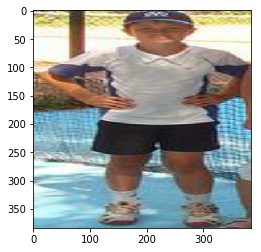

In [10]:
plt.imshow(orig_img)

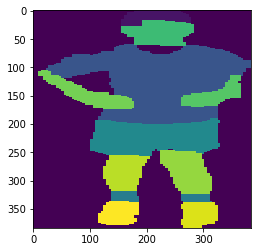

In [12]:
plt.imshow(segment.cpu())

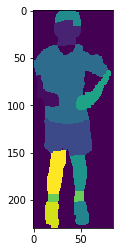

In [13]:
rev_img = Image.open(REVERSE_DIR + image_id + ".png")
plt.imshow(np.array(rev_img) * 120)

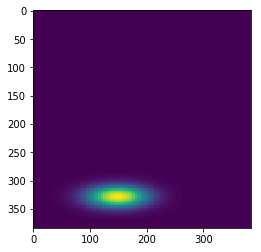

In [16]:
plt.imshow(heatmap[0,0,:,:].cpu())

In [17]:
parsing_net = ParsingNet(20).to(device)
pose_net = PoseNet().to(device)
pose_refine = PoseRefineNet(20).to(device)
parsing_refine = ParsingRefineNet(20).to(device)
backbone = BackboneResNet().to(device)

In [18]:
backbone.load_state_dict(torch.load("parameters/backbone_parameter.pt"))
parsing_net.load_state_dict(torch.load("parameters/parsing_net_parameter.pt"))
parsing_refine.load_state_dict(torch.load("parameters/parsing_refine_net_parameter.pt"))
pose_net.load_state_dict(torch.load("parameters/pose_net_parameter.pt"))
pose_refine.load_state_dict(torch.load("parameters/pose_refine_net_parameter.pt"))

<All keys matched successfully>

In [16]:
# parsing_net = nn.DataParallel(parsing_net)
# pose_net = nn.DataParallel(pose_net)
# pose_refine = nn.DataParallel(pose_refine)
# parsing_refine = nn.DataParallel(parsing_refine)
# backbone = nn.DataParallel(backbone)

In [19]:
transform = transforms.Compose([myTensor()])
img_100 = transform(orig_img)
orig_img_size = tuple(img_100.shape[1:])

transform_075 = transforms.Compose([transforms.Resize(tuple([int(t*0.75) for t in orig_img_size])),
                                    myTensor()])
img_075 = transform_075(orig_img)

transform_050 = transforms.Compose([transforms.Resize(tuple([int(t*0.5) for t in orig_img_size])),
                                    myTensor()])
img_050 = transform_050(orig_img)

In [20]:
img_100 = img_100.unsqueeze(0)
img_100_reverse = torch.flip(img_100, dims=[2])
print(img_100.shape)

img_075 = img_075.unsqueeze(0)
img_075_reverse = torch.flip(img_075, dims=[2])
print(img_075.shape)

img_050 = img_050.unsqueeze(0)
img_050_reverse = torch.flip(img_050, dims=[2])
print(img_050.shape)

torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 288, 288])
torch.Size([1, 3, 192, 192])


In [21]:
# input_img_100 = torch.cat((img_100,img_100_reverse), dim=0).to(device)
# #input_img = img.to(device) # only use orig img
# input_img_075 = torch.cat((img_075,img_075_reverse), dim=0).to(device)
# input_img_050 = torch.cat((img_050,img_050_reverse), dim=0).to(device)

# print(input_img_100.shape)

In [22]:
input_img_100 = img_100.to(device) # only use orig img
input_img_075 = img_075.to(device)
input_img_050 = img_050.to(device)

print(input_img_100.shape)

torch.Size([1, 3, 384, 384])


In [23]:
feature_map_100 = backbone(input_img_100)

parsing_map1_100, parsing_context1_100 = parsing_net(feature_map_100)
pose_map1_100, pose_context1_100 = pose_net(feature_map_100)

pose_map2_100, pose_context2_100 = pose_refine(pose_map1_100, parsing_map1_100, pose_context1_100)
parsing_map2_100, parsing_context2_100 = parsing_refine(pose_map1_100, parsing_map1_100, parsing_context1_100)
parsing_map3_100, parsing_context3_100 = parsing_refine(pose_map2_100, parsing_map2_100, parsing_context2_100)
pose_map3_100, pose_context3_100 = pose_refine(pose_map2_100, parsing_map2_100, pose_context2_100)

In [24]:
feature_map_075 = backbone(input_img_075)

parsing_map1_075, parsing_context1_075 = parsing_net(feature_map_075)
pose_map1_075, pose_context1_075 = pose_net(feature_map_075)

pose_map2_075, pose_context2_075 = pose_refine(pose_map1_075, parsing_map1_075, pose_context1_075)
parsing_map2_075, parsing_context2_075 = parsing_refine(pose_map1_075, parsing_map1_075, parsing_context1_075)
parsing_map3_075, parsing_context3_075 = parsing_refine(pose_map2_075, parsing_map2_075, parsing_context2_075)
pose_map3_075, pose_context3_075 = pose_refine(pose_map2_075, parsing_map2_075, pose_context2_075)

In [25]:
feature_map_050 = backbone(input_img_050)

parsing_map1_050, parsing_context1_050 = parsing_net(feature_map_050)
pose_map1_050, pose_context1_050 = pose_net(feature_map_050)

pose_map2_050, pose_context2_050 = pose_refine(pose_map1_050, parsing_map1_050, pose_context1_050)
parsing_map2_050, parsing_context2_050 = parsing_refine(pose_map1_050, parsing_map1_050, parsing_context1_050)
parsing_map3_050, parsing_context3_050 = parsing_refine(pose_map2_050, parsing_map2_050, parsing_context2_050)
pose_map3_050, pose_context3_050 = pose_refine(pose_map2_050, parsing_map2_050, pose_context2_050)

In [26]:
parsing_map1_size = parsing_map1_100.shape[2:4]
parsing_map1 = torch.mean(torch.stack((parsing_map1_100,
                                     F.interpolate(parsing_map1_075, size=parsing_map1_size, mode="bilinear", align_corners=True),
                                     F.interpolate(parsing_map1_050, size=parsing_map1_size, mode="bilinear", align_corners=True))), dim=0)

In [27]:
parsing_map2_size = parsing_map2_100.shape[2:4]
parsing_map2 = torch.mean(torch.stack((parsing_map2_100,
                                     F.interpolate(parsing_map2_075, size=parsing_map2_size, mode="bilinear", align_corners=True),
                                     F.interpolate(parsing_map2_050, size=parsing_map2_size, mode="bilinear", align_corners=True))), dim=0)

In [28]:
parsing_map3_size = parsing_map3_100.shape[2:4]
parsing_map3 = torch.mean(torch.stack((parsing_map3_100,
                                     F.interpolate(parsing_map3_075, size=parsing_map3_size, mode="bilinear", align_corners=True),
                                     F.interpolate(parsing_map3_050, size=parsing_map3_size, mode="bilinear", align_corners=True))), dim=0)

In [29]:
pose_map1_size = pose_map1_100.shape[2:4]
pose_map1 = torch.mean(torch.stack((pose_map1_100,
                                     F.interpolate(pose_map1_100, size=pose_map1_size),
                                     F.interpolate(pose_map1_100, size=pose_map1_size))), dim=0)

In [30]:
pose_map2_size = pose_map2_100.shape[2:4]
pose_map2 = torch.mean(torch.stack((pose_map2_100,
                                     F.interpolate(pose_map2_100, size=pose_map2_size),
                                     F.interpolate(pose_map2_100, size=pose_map2_size))), dim=0)

In [31]:
pose_map3_size = pose_map3_100.shape[2:4]
pose_map3 = torch.mean(torch.stack((pose_map3_100,
                                     F.interpolate(pose_map3_100, size=pose_map3_size),
                                     F.interpolate(pose_map3_100, size=pose_map3_size))), dim=0)

In [32]:
raw_prediction_p1 = parsing_map1.reshape(N_CLASSES, -1)
raw_prediction_p1_100 = parsing_map1_100.reshape(N_CLASSES, -1)
raw_prediction_p1_075 = parsing_map1_075.reshape(N_CLASSES, -1)
raw_prediction_p1_050 = parsing_map1_050.reshape(N_CLASSES, -1)

In [33]:
raw_prediction_p2 = parsing_map2.reshape(N_CLASSES, -1)
raw_prediction_p2_100 = parsing_map2_100.reshape(N_CLASSES, -1)
raw_prediction_p2_075 = parsing_map2_075.reshape(N_CLASSES, -1)
raw_prediction_p2_050 = parsing_map2_050.reshape(N_CLASSES, -1)

In [34]:
raw_prediction_p3 = parsing_map3.reshape(N_CLASSES, -1)
raw_prediction_p3_100 = parsing_map3_100.reshape(N_CLASSES, -1)
raw_prediction_p3_075 = parsing_map3_075.reshape(N_CLASSES, -1)
raw_prediction_p3_050 = parsing_map3_050.reshape(N_CLASSES, -1)

In [35]:
new_segment = segment.reshape(-1,1,segment.shape[0],segment.shape[1]).float()

label_proc_100 = F.interpolate(new_segment, size=parsing_map1_100.shape[2:4]).int().squeeze()
label_proc_075 = F.interpolate(new_segment, size=parsing_map1_075.shape[2:4]).int().squeeze()
label_proc_050 = F.interpolate(new_segment, size=parsing_map1_050.shape[2:4]).int().squeeze()

In [36]:
raw_gt_100 = label_proc_100.reshape(-1) 
raw_gt_075 = label_proc_075.reshape(-1) 
raw_gt_050 = label_proc_050.reshape(-1) 

In [37]:
indices_100 = (raw_gt_100 <= N_CLASSES-1).nonzero().reshape(-1)
indices_075 = (raw_gt_075 <= N_CLASSES-1).nonzero().reshape(-1)
indices_050 = (raw_gt_050 <= N_CLASSES-1).nonzero().reshape(-1)

In [38]:
gt_100 = torch.index_select(raw_gt_100, dim=0, index=indices_100)
gt_075 = torch.index_select(raw_gt_075, dim=0, index=indices_075)
gt_050 = torch.index_select(raw_gt_050, dim=0, index=indices_050)

In [39]:
prediction_p1 = torch.index_select(raw_prediction_p1, dim=1, index=indices_100)
prediction_p1_100 = torch.index_select(raw_prediction_p1_100, dim=1, index=indices_100)
prediction_p1_075 = torch.index_select(raw_prediction_p1_075, dim=1, index=indices_075)
prediction_p1_050 = torch.index_select(raw_prediction_p1_050, dim=1, index=indices_050)

In [40]:
prediction_p2 = torch.index_select(raw_prediction_p2, dim=1, index=indices_100)
prediction_p2_100 = torch.index_select(raw_prediction_p2_100, dim=1, index=indices_100)
prediction_p2_075 = torch.index_select(raw_prediction_p2_075, dim=1, index=indices_075)
prediction_p2_050 = torch.index_select(raw_prediction_p2_050, dim=1, index=indices_050)

In [41]:
prediction_p3 = torch.index_select(raw_prediction_p3, dim=1, index=indices_100)
prediction_p3_100 = torch.index_select(raw_prediction_p3_100, dim=1, index=indices_100)
prediction_p3_075 = torch.index_select(raw_prediction_p3_075, dim=1, index=indices_075)
prediction_p3_050 = torch.index_select(raw_prediction_p3_050, dim=1, index=indices_050)

In [43]:
heatmap_100 = F.interpolate(heatmap, size=pose_map1_100.shape[2:4])
heatmap_075 = F.interpolate(heatmap, size=pose_map1_075.shape[2:4])
heatmap_050 = F.interpolate(heatmap, size=pose_map1_050.shape[2:4])

In [44]:
loss_p1 = F.nll_loss(F.softmax(prediction_p1.unsqueeze(0), dim=1), gt_100.unsqueeze(0).long())

loss_p1_100 = F.nll_loss(F.softmax(prediction_p1_100.unsqueeze(0), dim=1), gt_100.unsqueeze(0).long())
loss_p1_075 = F.nll_loss(F.softmax(prediction_p1_075.unsqueeze(0), dim=1), gt_075.unsqueeze(0).long())
loss_p1_050 = F.nll_loss(F.softmax(prediction_p1_050.unsqueeze(0), dim=1), gt_050.unsqueeze(0).long())

In [45]:
loss_p2 = F.nll_loss(F.softmax(prediction_p2.unsqueeze(0), dim=1), gt_100.unsqueeze(0).long())

loss_p2_100 = F.nll_loss(F.softmax(prediction_p2_100.unsqueeze(0), dim=1), gt_100.unsqueeze(0).long())
loss_p2_075 = F.nll_loss(F.softmax(prediction_p2_075.unsqueeze(0), dim=1), gt_075.unsqueeze(0).long())
loss_p2_050 = F.nll_loss(F.softmax(prediction_p2_050.unsqueeze(0), dim=1), gt_050.unsqueeze(0).long())

In [46]:
loss_p3 = F.nll_loss(F.softmax(prediction_p3.unsqueeze(0), dim=1), gt_100.unsqueeze(0).long())

loss_p3_100 = F.nll_loss(F.softmax(prediction_p3_100.unsqueeze(0), dim=1), gt_100.unsqueeze(0).long())
loss_p3_075 = F.nll_loss(F.softmax(prediction_p3_075.unsqueeze(0), dim=1), gt_075.unsqueeze(0).long())
loss_p3_050 = F.nll_loss(F.softmax(prediction_p3_050.unsqueeze(0), dim=1), gt_050.unsqueeze(0).long())

In [47]:
loss_s1 = torch.mean(torch.sqrt(torch.sum(((heatmap_100 - pose_map1)**2), (1,2,3))))

loss_s1_100 = torch.mean(torch.sqrt(torch.sum(((heatmap_100 - pose_map1_100)**2), (1,2,3))))
loss_s1_075 = torch.mean(torch.sqrt(torch.sum(((heatmap_075 - pose_map1_075)**2), (1,2,3))))
loss_s1_050 = torch.mean(torch.sqrt(torch.sum(((heatmap_050 - pose_map1_050)**2), (1,2,3))))

In [48]:
loss_s2 = torch.mean(torch.sqrt(torch.sum(((heatmap_100 - pose_map2)**2), (1,2,3))))

loss_s2_100 = torch.mean(torch.sqrt(torch.sum(((heatmap_100 - pose_map2_100)**2), (1,2,3))))
loss_s2_075 = torch.mean(torch.sqrt(torch.sum(((heatmap_075 - pose_map2_075)**2), (1,2,3))))
loss_s2_050 = torch.mean(torch.sqrt(torch.sum(((heatmap_050 - pose_map2_050)**2), (1,2,3))))

In [49]:
loss_s3 = torch.mean(torch.sqrt(torch.sum(((heatmap_100 - pose_map3)**2), (1,2,3))))

loss_s3_100 = torch.mean(torch.sqrt(torch.sum(((heatmap_100 - pose_map3_100)**2), (1,2,3))))
loss_s3_075 = torch.mean(torch.sqrt(torch.sum(((heatmap_075 - pose_map3_075)**2), (1,2,3))))
loss_s3_050 = torch.mean(torch.sqrt(torch.sum(((heatmap_050 - pose_map3_050)**2), (1,2,3))))

In [50]:
loss_parsing = loss_p1 + loss_p1_100 + loss_p1_075 + loss_p1_050 + loss_p2 + loss_p2_100 + loss_p2_075 + loss_p2_050 + loss_p3 + loss_p3_100 + loss_p3_075 + loss_p3_050
loss_pose = loss_s1 + loss_s1_100 + loss_s1_075 + loss_s1_050 + loss_s2 + loss_s2_100 + loss_s2_075 + loss_s2_050 + loss_s3 + loss_s3_100 + loss_s3_075 + loss_s3_050
reduced_loss =  loss_pose * pose_weight + loss_parsing * parsing_weight

In [59]:
base_lr = LEARNING_RATE
#learning_rate = tf.scalar_mul(base_lr, ((1 - step_ph / NUM_STEPS), POWER)**2)
params = list(parsing_net.parameters()) + list(pose_net.parameters()) + list(pose_refine.parameters()) + list(parsing_refine.parameters()) + list(backbone.parameters())

optimizer = torch.optim.RMSprop(params, lr=base_lr, momentum=MOMENTUM)